In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # 打印函数图像

先初始化相关参数。
比如 初始的种群规模，变异概率，交叉概率等
以及函数的定义域等

In [2]:
max_epoches = 400  # 最大的迭代次数
cmp = 0.95  # 种群交叉的概率
mop = 0.05  # 种群变异的概率

fun_one_bound = [-5.12, 5.12]
fun_two_bound = [-2.048, 2.048]

best_fitness = []  # 每一代的最好的适应度
all_fitness = []  # 所有代所有个体的适应度
one_fitness = []  # 某一代所有个体的适应度

# 初始化最开始的种群规模
first_population = np.random.randint(low=0, high=2, size=(200, 2, 20))


In [3]:
# 打印出first_population
first_population

array([[[1, 0, 0, ..., 1, 1, 0],
        [0, 1, 1, ..., 1, 1, 0]],

       [[1, 0, 1, ..., 0, 0, 1],
        [1, 1, 1, ..., 0, 1, 1]],

       [[1, 1, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       ...,

       [[0, 1, 1, ..., 0, 1, 1],
        [1, 1, 0, ..., 1, 1, 0]],

       [[1, 0, 0, ..., 0, 1, 0],
        [1, 1, 0, ..., 0, 1, 1]],

       [[1, 1, 0, ..., 1, 1, 0],
        [1, 0, 0, ..., 0, 1, 1]]])

接下来定义三个函数，分别是目标函数1和2，以及画出三个目标函数的函数

In [4]:
def function_one(x1, x2):  # 范围：-5.12<= x <= 5.12
    return x1 ** 2 + x2 ** 2


def function_two(x1, x2):  # 范围：-2.048<= x <= 2.048
    return 100 * (x1 ** 2 - x2) ** 2 + (1 - x1) ** 2


def show_image(ax, func, x1_bound, x2_bound):
    x1, x2 = np.linspace(*x1_bound), np.linspace(*x2_bound)
    x1, x2 = np.meshgrid(x1, x2)

    ax.plot_surface(x1, x2, func(x1, x2), rstride=1,
                    cstride=1, cmap=cm.coolwarm)

    ax.set_zlim(-20, 60)  # 设置z轴的范围

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    plt.pause(3)
    plt.show()

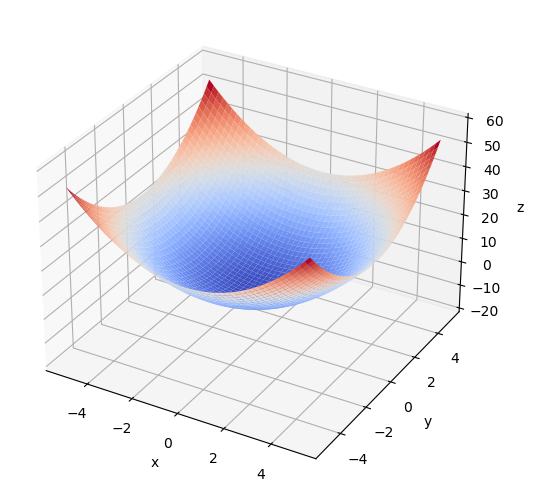

In [5]:
# 比如我们打印出第一个函数来观察一下
fig = plt.figure()
ax = Axes3D(fig)
show_image(ax,function_one,fun_one_bound,fun_one_bound)

映射函数 && 获取适应度。
我们首先把每一个生成的染色体进行映射，映射到对应的函数定义域的范围内
接下来进行遍历，获取每一个染色体的适应度

将一个二进制串代表的二进制数转化为10进制数：$(b_0b_1...b_{21})_2=x^{t} $ 
对应区间内的实数：$x=-1+x^{t}\frac{(2-(-1))}{2^{22}-1}$

In [6]:
def reflect_fuc(each, func_bound):
    # 传入每一对以及函数的定义域范围。
    # 建立二进制编码到一个实数的映射。
    x_, y_ = 0, 0

    for i in range(10):
        x_ += each[0][i]*(2**i)
    for i in range(10):
        y_ += each[1][i]*(2**i)

    fin_x = (x_/(2**10-1))*(func_bound[1]-func_bound[0])+func_bound[0]
    fin_y = (y_/(2**10-1))*(func_bound[1]-func_bound[0])+func_bound[0]
    return fin_x, fin_y

def get_fitness(first_population,function,func_bound): 
    # 获取所有个体的适应度
    # 传入初始的种群，函数以及函数的定义域
    each_fitness=[]
    for each in first_population:
        x_1,x_2=reflect_fuc(each,func_bound)  # 映射得到x1,x2
        each_fitness.append(function(x_1,x_2)) # 添加到fitness
    return each_fitness

选择函数
GA算法中常见的选择操作是轮盘赌方式。
轮盘赌方式是种群中适应度值更优的个体被选择的概率越大。
假设popsize=4，按照如下表达式计算各个个体的被选择概率的大小。
$P(X_j) = \frac{fit(X_j)}{(fit(X_1)+fit(X_2)+fit(X_3)+fit(X_4))},j=1,2,3,4$

In [7]:
def rws_algoritm(first_population, fitness, n):  # 定义轮盘赌算法
    next_population = []  # 定义下一个子代
    sum_ = sum(fitness)  # 获取所有的适应度的和

    p_ = ((sum_-fitness)/sum_) / (len(fitness)-1) # 获得概率

    idx = np.random.choice(np.arange(len(first_population)), size=n, replace=True, p=p_)

    for i in idx:
        next_population.append(first_population[i])
    return next_population

交叉编译函数 && 变异函数

In [8]:
def mutation(first_population, mop):  # 变异
    next_population = []  # 定义下一代
    for each in first_population:  # 遍历
        res = each  # 子代变成父代(进行更新)
        if np.random.rand() < mop:  # 随机初始化一个数 比他大不发生变化 比他小就发生交叉交换
            # 定义x_mu_place 是发生变异的位置
            x_mu_place = np.random.randint(0, len(each[0]))
            res[0][x_mu_place] = abs(res[0][x_mu_place]-1)

        if np.random.rand() < mop:  # 随机初始化一个数 比他大不发生变化 比他小就发生交叉交换
            # 同理，y_place 也是一样的。
            y_mu_place = np.random.randint(0, len(each[1]))
            res[1][y_mu_place] = abs(res[1][y_mu_place]-1)

        next_population.append(res)
    return next_population

def cross_mutation(first_population,cmp):  # 交叉与变异
    next_population=[] # 定义下一代
    for each in first_population: # 遍历
        res=each # 子代变成父代
        if np.random.rand() < cmp: # 随机初始化一个数 比他大不发生变化 比他小就发生交叉交换
            # 随机从first_population中生成一段，然后进行交换
            random_length=first_population[np.random.randint(0,len(first_population))] # 另一个

            # 定义随机生成的x交叉点和y交叉点
            x_c_m_pos=np.random.randint(0,len(random_length[0]))
            y_c_m_pos=np.random.randint(0,len(random_length[1]))

            for i in range(x_c_m_pos,len(random_length[0])):
                res[0][i]=random_length[0][i] # 赋值,剪切之后交换
            for j in range(y_c_m_pos,len(random_length[1])):
                res[1][j]=random_length[1][j] # 赋值,剪切之后交换

        next_population.append(res)
    return next_population

最后一步进行选择，我们定义精英是最小的，因为我们要求函数的最小值。
首先我们初始化fitness,然后进行迭代，迭代之后我们再次生成fitness

In [9]:
def nature_selection(function,parent,cop,mop,fun_bound):  # 自然选择
    
    next_population,fitness,best_best=[],[],[] # 下一代 && 适应度 && 精英
    
    fitness=get_fitness(parent,function,fun_bound)  # 获取适应度
    best_idx=fitness.index(np.min(fitness)) # 找到最小的那个
    best_best=parent[best_idx].copy() # 找到最好的那个值，下标，当作是精英
    
    # 接下来进行变异，交叉和变异，轮盘选择，再进行fitness的测试
    # 每一个产生的next_作为下一个输入的种群
    
    next_population=mutation(parent,mop)
    next_population=cross_mutation(next_population,cop)
    next_population=rws_algoritm(next_population,fitness,len(next_population)-1)
    
    next_population.append(best_best) # 添加精英进去
    
    fitness=get_fitness(next_population,function,fun_bound)  # 再一次获取适应度
    
    return next_population


定义主函数，并且画出图像

In [10]:
for i in range(max_epoches):   # 最大的迭代次数
    first_population=nature_selection(function_one,first_population,cmp,mop,fun_one_bound)
    one_fitness=get_fitness(first_population,function_one,fun_one_bound)
    all_fitness.append(one_fitness)
    best_fitness.append(np.min(one_fitness))

print("finish")

finish


average:0.013822483856634643
max_element:0.22989880184877856
min_element:0.0006512713933393305


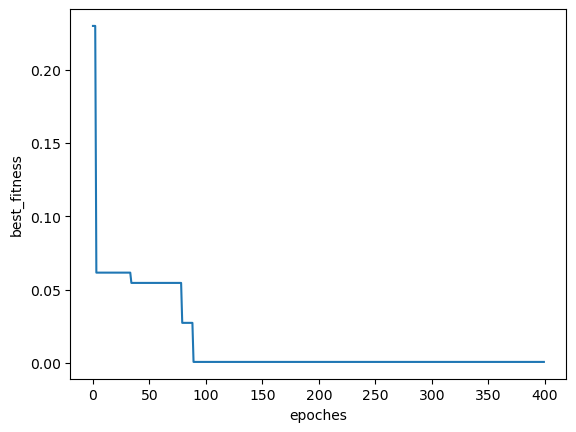

In [14]:
# 画图
print("average:{}".format(sum(best_fitness)/len(best_fitness)))
print("max_element:{}".format(max(best_fitness)))
print("min_element:{}".format(min(best_fitness)))

plt.plot(np.arange(max_epoches),best_fitness)
plt.xlabel("epoches")
plt.ylabel("best_fitness")
plt.show()

In [12]:
# 打印出所有的最好的适应度
print(best_fitness)

[0.22989880184877856, 0.22989880184877856, 0.22989880184877856, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.06157019557030884, 0.05455650364203947, 0.05455650364203947, 0.05455650364203947, 0.05455650364203947, 0.05455650364203947, 0.05455650364203947, 0.05455650364203947, 0.05455650364203947, 0.05455650364203947, 0.05455650364203947, 0.05455650364203947, 0.05455650364203947, 0.05455650364203947, 0.0545565036

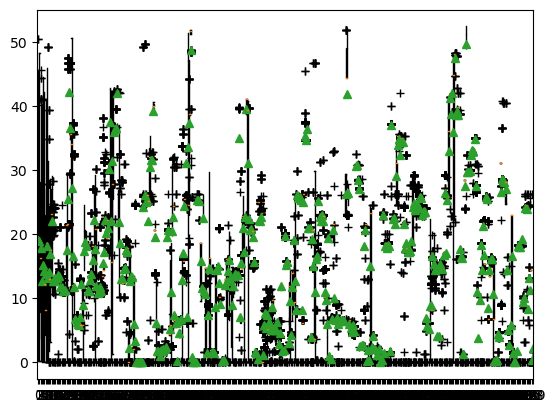

In [13]:
# 画出每一代的图形
plt.boxplot(all_fitness, labels = np.arange(max_epoches), 
                         sym = "+",
                         widths=0.6,    # 指定箱线图的宽度，默认为0.5；
                         patch_artist=True,    # 是否填充箱体的颜色；
                         showmeans=True
)
plt.show()